In [98]:
# import tensorflow
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# from tensorflow import keras
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import string 
import nltk
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import load_model


In [2]:
# Mounting the Drive Folder
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


### Reading Dataset

In [54]:
column_names=['Emotions','Sentences']
df= pd.read_csv("drive/My Drive/Training_AI_Engineers/isear_dataset.csv", names=column_names)
df.head()

,Emotions,Sentences
0,joy,On days when I feel close to my partner and ot...
1,fear,Every time I imagine that someone I love or I ...
2,anger,When I had been obviously unjustly treated and...
3,sadness,When I think about the short time that we live...
4,disgust,At a gathering I found myself involuntarily si...


In [56]:
df.dropna(inplace=True)

In [58]:
print("The emotions to be classified are: "+ str(list(df.Emotions.unique().tolist())))

The emotions to be classified are: ['joy', 'fear', 'anger', 'sadness', 'disgust', 'shame', 'guilt']


In [59]:
print("We need to classify "+ str(df.Emotions.nunique()) +" emotions now.")
print("The emotions to be classified are: "+ str(list(df.Emotions.unique())))

We need to classify 7 emotions now.
The emotions to be classified are: ['joy', 'fear', 'anger', 'sadness', 'disgust', 'shame', 'guilt']


In [60]:
from collections import Counter
Counter(df["Emotions"].values)

Counter({'anger': 1069,
         'disgust': 1059,
         'fear': 1063,
         'guilt': 1040,
         'joy': 1082,
         'sadness': 1074,
         'shame': 1059})

In [61]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Data Cleaning

In [63]:
def clean_text(text):
    text=text.translate(string.punctuation)
    text=text.lower().split()
    
    from nltk.corpus import stopwords
    stops=set(stopwords.words("english"))
    text=[w for w in text if not w in stops]
    text=" ".join(text)
    return text

df['Sentences']=df['Sentences'].map(lambda x:clean_text(x))

In [64]:
X, y = df['Sentences'], df['Emotions']

In [65]:
y[:20]

0         joy
1        fear
2       anger
3     sadness
4     disgust
5       shame
6       guilt
7         joy
8        fear
9       anger
10    sadness
11    disgust
12      shame
13      guilt
14        joy
15       fear
16      anger
17    sadness
18    disgust
19      shame
Name: Emotions, dtype: object

### Hot Encoding target

In [133]:
from keras.utils import np_utils
encoder=LabelEncoder()
encoder.fit(y)
encoded_y=encoder.transform(y)
onehot_y=np_utils.to_categorical(encoded_y)

In [119]:
len(onehot_y[0])

7

In [68]:
vocab=set()
a=[vocab.add(el) for s in X.values for el in s.split(' ')]
print("Total Unique Words:",len(a))

Total Unique Words: 79326


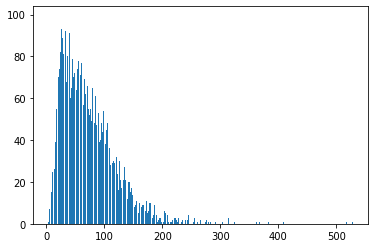

Min:  4
Median:  63.0
max:  528


In [69]:
l=[len(s) for s in X.values]
counts=Counter(l)
plt.bar(counts.keys(),counts.values())
plt.show()
print("Min: ",min(l))
print("Median: ",np.median(l))
print("max: ",max(l))

### Feature Engineering: Tokenizing and Embeddings

In [70]:
vocabulary_size = 80896  # Select an Appropriate Vobabulary Size
padded_length = 150  # Select an Appropriate padded Length for text
tokenizer =Tokenizer(num_words=vocabulary_size)
tokenizer.fit_on_texts(X)

In [71]:
def preprocessing(X):
    sequences = tokenizer.texts_to_sequences(X)
    data = pad_sequences(sequences, maxlen= padded_length) 
    return data

data = preprocessing(X)

### Train Test Split

In [72]:
X_train, X_test, y_train, y_test = train_test_split(data, onehot_y, test_size=0.1, random_state=101)

### Model Building

In [82]:
learning_rate = 1e-2
numEpoch = 20
embedding_size=200
lstm_size=64

import tensorflow as tf
import keras
from keras import optimizers, regularizers
from keras.layers import Dense, Flatten, LSTM, Dropout, Activation
from keras.layers.embeddings import Embedding


def create_model(embedding_size=100,lstm_size=32,layer1_size=32,dropoutrate=0.3):
    model=keras.models.Sequential()
    model.add(Embedding(vocabulary_size,embedding_size,input_length=padded_length,embeddings_regularizer=regularizers.l1(0.001)))
    model.add(LSTM(lstm_size,dropout=dropoutrate, recurrent_dropout=dropoutrate))
    model.add(Dense(layer1_size,activation='relu'))
    model.add(Dropout(dropoutrate,seed=seed))
    model.add(Dense(7,activation="softmax"))
    optim=optimizers.Adam(lr=learning_rate,beta_1=0.9,beta_2=0.999,epsilon=1e-08,decay=learning_rate/numEpoch)
    model.compile(loss='categorical_crossentropy',optimizer=optim,metrics=["accuracy"])
    model.summary()
    return model


model=create_model(embedding_size=embedding_size,lstm_size=lstm_size,layer1_size=32, dropoutrate=0.3)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 150, 200)          16179200  
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                67840     
_________________________________________________________________
dense_6 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 7)                 231       
Total params: 16,249,351
Trainable params: 16,249,351
Non-trainable params: 0
_________________________________________________________________


In [93]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot(history):
    """ Plots model loss from model train history"""
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model_loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train','validation'],loc='upper right')
    plt.show()

In [85]:
X_train

array([[   0,    0,    0, ...,   27, 1072, 3288],
       [   0,    0,    0, ..., 1318,  522, 1063],
       [   0,    0,    0, ..., 1699,  134, 1536],
       ...,
       [   0,    0,    0, ...,    2,   65,  785],
       [   0,    0,    0, ...,    6,  102,  651],
       [   0,    0,    0, ..., 1113,  536, 1297]], dtype=int32)

In [86]:
y_train

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [87]:
y_train[0]

array([0., 0., 0., 0., 1., 0., 0.], dtype=float32)

Epoch 1/20
42/42 [==============================] - 36s 806ms/step - loss: 130.6320 - accuracy: 0.1575 - val_loss: 25.3351 - val_accuracy: 0.1573
Epoch 2/20
42/42 [==============================] - 33s 798ms/step - loss: 24.1107 - accuracy: 0.1670 - val_loss: 23.0018 - val_accuracy: 0.2051
Epoch 3/20
42/42 [==============================] - 34s 799ms/step - loss: 22.5844 - accuracy: 0.2147 - val_loss: 22.9077 - val_accuracy: 0.3147
Epoch 4/20
42/42 [==============================] - 33s 795ms/step - loss: 22.1325 - accuracy: 0.3072 - val_loss: 21.8906 - val_accuracy: 0.3758
Epoch 5/20
42/42 [==============================] - 33s 795ms/step - loss: 21.7682 - accuracy: 0.4069 - val_loss: 22.7772 - val_accuracy: 0.4586
Epoch 6/20
42/42 [==============================] - 34s 801ms/step - loss: 21.4519 - accuracy: 0.4907 - val_loss: 20.3389 - val_accuracy: 0.5093
Epoch 7/20
42/42 [==============================] - 34s 798ms/step - loss: 20.7553 - accuracy: 0.5271 - val_loss: 20.9086 - val_a

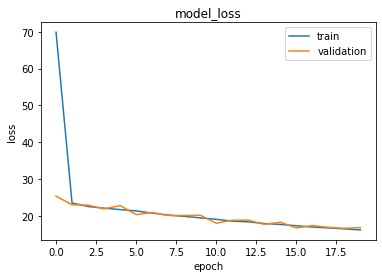

In [88]:
history =model.fit(X_train,y_train,batch_size=128,validation_split=0.2,epochs=numEpoch)

plot(history)

In [96]:
# model.save("drive/My Drive/Training_AI_Engineers/isear_lstm")

INFO:tensorflow:Assets written to: drive/My Drive/Training_AI_Engineers/isear_lstm/assets


In [99]:
model = load_model("drive/My Drive/Training_AI_Engineers/isear_lstm")

In [100]:
# train_model = mode
score = model.evaluate(X_test, y_test) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

24/24 [==============================] - 2s 60ms/step - loss: 16.5972 - accuracy: 0.5315
Test score: 16.597240447998047
Test accuracy: 0.5315436124801636


In [101]:
X_test

array([[   0,    0,    0, ...,  453,  954,    1],
       [   0,    0,    0, ...,  932,   34,  376],
       [   0,    0,    0, ...,   98,  266,  305],
       ...,
       [   0,    0,    0, ...,  650,    2,   68],
       [   0,    0,    0, ...,  117, 4632, 1276],
       [   0,    0,    0, ...,   66, 5887,   76]], dtype=int32)

In [110]:
len(model.predict(X_test[0]))

150

In [113]:
len(X_test)

745

In [91]:
from sklearn import metrics
prediction=model.predict(X_test)

test_y=encoder.inverse_transform(np.argmax(y_test,axis=1,out=None))
pred_y=encoder.inverse_transform(np.argmax(prediction,axis=1,out=None))
print (metrics.classification_report(test_y,pred_y))

              precision    recall  f1-score   support

       anger       0.44      0.50      0.46       105
     disgust       0.50      0.58      0.54       115
        fear       0.62      0.60      0.61        99
       guilt       0.50      0.43      0.46       104
         joy       0.69      0.59      0.64       115
     sadness       0.59      0.61      0.60       107
       shame       0.41      0.40      0.41       100

    accuracy                           0.53       745
   macro avg       0.54      0.53      0.53       745
weighted avg       0.54      0.53      0.53       745



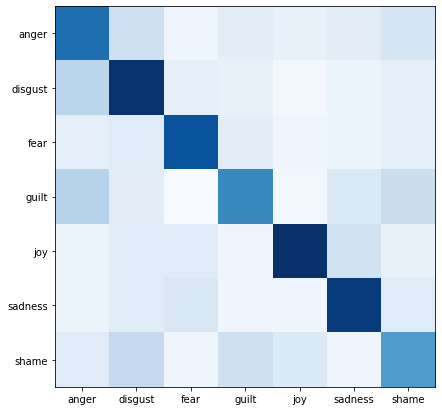

In [92]:
cm=metrics.confusion_matrix(test_y,pred_y)
plt.figure(figsize=(7,7))
plt.imshow(cm,interpolation='nearest',cmap='Blues')
ticks=encoder.inverse_transform(range(7)).astype(str)
plt.xticks(range(7),ticks)
plt.yticks(range(7),ticks)
plt.show()

In [106]:
model.predict(X_test[0])[0]

array([0.12698969, 0.13594648, 0.1502062 , 0.11826833, 0.13407204,
       0.20582294, 0.12869431], dtype=float32)

In [105]:
X_test[0][0]

0

In [117]:
def predict_sentiment(inpText):
  '''
  Function to predict the Sentiment of the sentence given as input by the User

  Parameters:
  ----------

  inpText/inputText: Given Text input by the user
  tokenizedSeq: Tokenizing the input text into sequences in the similar way
                 as done during the training preprocessing steps
  padSeq: Padding the Sequence in the same shape as done in training
  sentiment_value: 1 or 0 result obtained after the Sentiments Prediction
  sentiment: Storing the resulting sentiments as Positive or Negative

  Returns:
  -------
  sentiment: Single string either Postive or Negative is returned on the basis of model prediction

  '''
  # Now, self validating the model by giving inputs on inputText variable
  inputText = inpText
  # to develop a tokenized sequence, we use the texts_to_sequences function from the tokenizer 
  tokenizedSeq = tokenizer.texts_to_sequences([inputText])

  # after this, padding the sequence is done to take the input to the shape in which the data are trained
  # we have to understand that when the sequences length gets differed then, the machine
  # learning model will fail to predict. So, we have to take the test input
  # to the same format as the training data which is fitted on the model
  # for this, we use the pad_sequences function
  padSeq = pad_sequences(tokenizedSeq,maxlen=len(tokenizedSeq[0]))

  # because our model has sigmoid activation on the final layer, the value that
  # is returned is between 0 and 1.
  # So, we have to follow the following steps to round the result either in 1 or 0
  # so, the model returns 1 if 0.5 or greater is predicted result else the model returns 0
  sentiment_value = model.predict(padSeq)

  # Based on the sentiment value, we can classify the input as positive or negative sentiments as
  # sentiment = sentiments[1][sentiment_value]

  # Finally, we return the sentiment i.e. either Postive or Negative from this function
  return sentiment_value

In [143]:
# For a quick demonstration, we can just give an Input and See whether the text
# bears a positive or a negative sentiments
# we can give the input as following:
inpText = input()
# and for making prediction of the given input, we can call our predict_sentiment
# function as predict_sentiment(inpText). In this way, we can give input and
# obtain predictions
print(f"Predicted Label: {predict_sentiment(inpText)}")

happy
Predicted Label: [[3.1071488e-04 5.4038432e-04 3.8485511e-04 1.2577145e-04 9.8628342e-01
  1.0142793e-02 2.2119884e-03]]


In [155]:
# For a quick demonstration, we can just give an Input and See whether the text
# bears a positive or a negative sentiments
# we can give the input as following:
inpText = input()
# and for making prediction of the given input, we can call our predict_sentiment
# function as predict_sentiment(inpText). In this way, we can give input and
# obtain predictions
emotion_prediction = predict_sentiment(inpText)
print(f"Predicted Label: {predict_sentiment(inpText)}")

i am happy with this model.
Predicted Label: [[0.01648395 0.01189517 0.00624375 0.00825585 0.8523542  0.0781191
  0.02664796]]


In [156]:
print(f"anger: {emotion_prediction[0][0]}")
print(f"disgust: {emotion_prediction[0][1]}")
print(f"fear: {emotion_prediction[0][2]}")
print(f"guilt: {emotion_prediction[0][3]}")
print(f"joy: {emotion_prediction[0][4]}")
print(f"sadness: {emotion_prediction[0][5]}")
print(f"shame: {emotion_prediction[0][6]}")

anger: 0.016483953222632408
disgust: 0.011895171366631985
fear: 0.006243749056011438
guilt: 0.008255849592387676
joy: 0.8523542284965515
sadness: 0.07811909914016724
shame: 0.026647960767149925
